### Dependencies

In [1]:
import tstables
import tables as tb
import numpy as np
import pandas as pd

from datetime import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.optimize import linprog
from scipy import optimize
from IPython.display import Image
import matplotlib.pyplot as plt

### Store Data with TsTables

It's not necessary, or even not recommended to use TsTables for the size of the dataset that we are dealing with. I learned about this tool from an algorithmic trading textbook and wanted to try applying it here. TsTables is generally designed for high-frequency or large time-series datasets, as it stores data on disk and allows reading specific time ranges without loading the entire file into memory. For S&P 500 daily data, it's an overkill, and Pandas or Polars is faster and simpler.

The set up of TsTables can be found in the `setup.py` file.

Open a pre-existing `clean_sp500_3yrs.h5ts` HDF5 file and get that timeseries from it.

In [2]:
h5 = tb.open_file('data/clean_sp500_3yrs.h5ts', 'r')
ts = h5.root.data._f_get_timeseries()

In [3]:
start = datetime(2023, 9, 25)
end = datetime(2023, 12, 23)

In [4]:
%time subset = ts.read_range(start, end)

CPU times: user 2.78 s, sys: 18.6 ms, total: 2.8 s
Wall time: 2.84 s


In [5]:
subset.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2023-09-25,110.069542,174.372025,142.726974,134.139999,93.269531,77.165421,306.313019,511.600006,169.505753,71.964928,...,29.559948,88.728226,55.439793,108.374245,88.894646,45.590000,120.205078,115.037331,228.149994,173.857681
2023-09-26,108.879738,170.292007,142.044052,132.279999,92.082977,77.270020,300.147888,506.299988,166.520081,70.819817,...,29.248793,88.757584,53.790295,108.542068,87.458496,44.810001,119.281685,110.243713,223.960007,173.026123
2023-09-27,108.653580,168.776840,141.324188,134.029999,91.413139,77.098854,303.790985,502.600006,166.974228,71.089798,...,29.258221,90.255157,53.315022,112.075905,88.230301,44.139999,117.329094,108.577209,225.910004,170.883713
2023-09-28,110.128502,169.034332,140.512039,136.470001,93.891525,77.631355,290.639374,504.670013,170.452667,70.791893,...,28.767914,89.432961,52.998165,111.395256,88.953270,44.349998,119.349007,110.483109,236.869995,170.228287
2023-09-29,109.951515,169.549271,137.567947,137.210007,92.676254,75.796120,296.765839,509.899994,169.177231,70.214676,...,28.909346,90.450920,53.324337,109.632996,88.933723,44.259998,120.176224,110.247330,236.529999,170.198929


### Compute Asset Returns

In [6]:
# function to compute stock returns
def compute_returns(stock_price_array):
    stock_returns = (stock_price_array[1:, :] - stock_price_array[:-1, :]) / stock_price_array[:-1, :]
    return stock_returns

In [7]:
%%time
start = datetime(2022, 10, 17)
end = datetime(2025, 10, 17) 
stock_price = ts.read_range(start, end)

CPU times: user 35.6 s, sys: 329 ms, total: 35.9 s
Wall time: 36.6 s


In [8]:
rows, columns = stock_price.shape
print('Total number of trading days over 3 years:', rows)
print('Total number of stocks:', columns)

Total number of trading days over 3 years: 754
Total number of stocks: 498


In [9]:
stock_price_array = stock_price.values
stock_returns = compute_returns(stock_price_array)
print('Daily returns of 498 S&P 500 stocks:')
print(stock_returns)
print('\nShape of daily stock returns:', stock_returns.shape)

Daily returns of 498 S&P 500 stocks:
[[ 0.01332732  0.00940961  0.00131568 ... -0.01339248  0.0085996
   0.00420578]
 [-0.02524558  0.00076533 -0.01016602 ... -0.00834626 -0.01299793
  -0.01522385]
 [-0.0234183  -0.00326715 -0.00139753 ... -0.01655574 -0.01624042
  -0.02497813]
 ...
 [ 0.01166329  0.00633649 -0.00558268 ...  0.0102673   0.01508708
  -0.00934066]
 [ 0.01038319 -0.00758001  0.00287328 ...  0.0054337   0.00197711
   0.00802139]
 [ 0.00581142  0.01955949  0.01190114 ...  0.02001601 -0.00210933
   0.00558427]]

Shape of daily stock returns: (753, 498)


### Compute Market Index Returns

In [10]:
%%time
index_df = pd.read_csv('data/index_sp500_3yrs.csv', index_col=0, parse_dates=True)

CPU times: user 2.63 ms, sys: 3.35 ms, total: 5.98 ms
Wall time: 17.1 ms


In [11]:
index_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2022-10-17 to 2025-10-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   754 non-null    float64
 1   High    754 non-null    float64
 2   Low     754 non-null    float64
 3   Open    754 non-null    float64
 4   Volume  754 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.3 KB


In [12]:
index_price = index_df[['Close']]
index_price_array = index_price.values
index_returns = compute_returns(index_price_array)
print('\nShape of daily index returns:', index_returns.shape)


Shape of daily index returns: (753, 1)


### Compute Mean and Covariance of Stock Returns

In [13]:
mean_returns = np.mean(stock_returns, axis=0)
print('Mean returns of 498 S&P 500 stocks:')
print(mean_returns)
cov_returns = np.cov(stock_returns, rowvar=False)
print('\nVariance-covariance matrix of returns of 498 S&P 500 stocks:')
print(cov_returns)

Mean returns of 498 S&P 500 stocks:
[ 3.06456723e-04  9.28870104e-04  8.67476621e-04  4.24117111e-04
  4.50773843e-04  9.74805214e-04  6.93666640e-05  4.02582167e-04
  1.02881373e-03 -1.12176289e-04  4.10558041e-04  7.55865996e-04
  6.05745660e-04  6.61310061e-04 -1.56557720e-04  9.61393515e-04
  7.33490158e-04  6.34869107e-04  7.47744910e-04  4.03491228e-05
 -6.48073430e-04 -8.11097334e-05  7.41688299e-04  1.03535195e-03
  1.85376578e-03 -1.06196821e-04  2.37979582e-03  7.26143430e-04
  4.66541021e-04  9.40486440e-04  2.61258899e-04  1.05227339e-03
  2.72509511e-03  4.12692439e-04  6.07748119e-04 -2.42585734e-04
  3.27931411e-04  1.89931579e-03  1.54013336e-03  5.74699718e-03
  2.28717865e-04 -3.86794309e-04  9.22948260e-04  3.22281512e-04
  3.25823833e-03  8.97558710e-05  3.05311553e-04  2.63632112e-03
  1.39260056e-03  8.41586322e-04  8.21403908e-04  8.01263097e-04
  1.92099272e-04 -8.13916458e-04  7.07752352e-04 -7.17023714e-05
  4.02269153e-04 -8.36434514e-04  4.23495802e-04 -6.98

In [14]:
print('Shape of mean returns:', mean_returns.shape)
print('Shape of variance-covariance matrix of returns:', cov_returns.shape)

Shape of mean returns: (498,)
Shape of variance-covariance matrix of returns: (498, 498)


### Compute Beta

In [15]:
# stock_returns shape: (753, 498); index_returns shape: (753, 1)
cov_matrix = np.cov(stock_returns, index_returns, rowvar=False)
print('Shape of covariance matrix:', cov_matrix.shape)
cov_with_index = cov_matrix[:-1, -1]
index_var = np.var(index_returns, ddof=1)
beta = cov_with_index / index_var
print('\nBeta coefficients:')
print(beta)
print('\nShape of Beta:', beta.shape)

Shape of covariance matrix: (499, 499)

Beta coefficients:
[ 1.01425317  1.25407516  0.3256551   1.48133391  0.40043457  0.48740419
  0.93939264  1.22096727  1.50886827  0.45072658  0.6789169   1.28978582
  0.33644753  0.24585382  1.05655675  0.53768775  0.72792824  0.6834245
  0.4581012   0.97669271  1.68645363  1.55116986  0.52203593  0.89557427
  1.78054509  0.67339394  2.05494315  0.83404654  0.48330119  1.1298007
  0.36641071  1.46208373  1.64691243  0.47443023  0.80852288  1.25043287
  0.72683355  1.25597428  1.57560986  2.30028287  1.28094303  0.98273986
  0.35307095  0.733086    1.84084599  0.79204021  0.23998555  0.96606541
  1.21444701  0.34019187  1.01232524  0.98889872  0.76204944  0.744342
  1.19010246  0.51806818  1.1874252   0.59269083  0.46869905  0.64903127
  0.88411     0.99736156  0.97694347  1.37909805  1.14856733  0.28935799
  0.76070474  0.63319173  0.5387734   0.63505584  1.6651976   1.16531843
  1.17308813  0.13861503  0.3353812   1.1951863   1.09563082  0.34117

In [16]:
beta_df = pd.DataFrame({
    'Stock': stock_price.columns,
    'Beta': beta
})
print('Top 20 most volatile stocks:\n')
print(beta_df.sort_values(by='Beta', ascending=False).head(20))

Top 20 most volatile stocks:

    Stock      Beta
102  COIN  2.589684
39    APP  2.300283
314  MPWR  2.298602
223  HOOD  2.283811
444  TSLA  2.203025
369  PLTR  2.200885
340  NVDA  2.161722
406  SMCI  2.118144
26    AMD  2.054943
493   XYZ  2.027238
349    ON  2.017965
296  MCHP  1.970198
284  LRCX  1.913791
430   TER  1.881319
81    CCL  1.879553
324    MU  1.877238
44   AVGO  1.840846
447   TTD  1.805581
266  KLAC  1.794558
24   AMAT  1.780545


### Principal Component Analysis
We can think of PCA as a partitioning of the variation in the data.

For now, we define feature/characteristic vector of each stock as its mean return + variance-covariance of its returns with other stocks.

In [17]:
feature_matrix = np.concatenate([mean_returns.reshape(-1, 1), cov_returns], axis=1)
print('Shape of the feature matrix:', feature_matrix.shape)

Shape of the feature matrix: (498, 499)


In [18]:
# standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)
X_scaled

array([[-0.56816116,  4.07560205,  0.11652581, ...,  1.14859476,
         0.48549676,  1.4181182 ],
       [ 0.20267571, -0.07455394,  3.51006995, ...,  0.03799078,
         0.33315256,  0.49509348],
       [ 0.12664206, -0.63500788, -1.31912409, ..., -0.1422172 ,
        -1.31268831, -0.77270279],
       ...,
       [-0.90219527, -0.36401781, -0.66133228, ...,  6.14602313,
        -0.51215899, -0.0433092 ],
       [-0.3445934 ,  1.9040603 ,  1.75780318, ...,  2.09046387,
         4.96117618,  2.50475575],
       [-0.78561676,  0.4514157 ,  0.05317914, ...,  0.88769983,
         0.07336679,  5.59256347]])

In [19]:
# create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# the max possible number of principal components equals the rank of X_scaled
component_labels = ['PC{}'.format(i+1) for i in range(pca.n_components_)]
X_pca = pd.DataFrame(X_pca, columns=component_labels)
print('Shape:', X_pca.shape, '\n')
X_pca.head()

Shape: (498, 498) 



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC489,PC490,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498
0,7.462692,5.145752,-4.372576,-6.231399,-2.820910,3.988588,2.700770,-1.212794,0.357487,-2.634799,...,-0.005384,-0.005993,-0.001348,0.004200,-0.001629,0.000545,0.000730,-0.000096,0.000021,7.625351e-17
1,3.946236,-4.451785,-4.752095,0.255295,-2.574090,-1.795662,1.005414,-0.065592,-2.976174,0.069296,...,-0.000113,-0.001572,0.004407,-0.001159,-0.004665,0.002067,-0.000829,-0.000344,-0.000037,7.625351e-17
2,-22.887418,-1.548461,0.211404,-5.945414,-1.382527,2.139143,2.864431,-3.510704,-0.029391,-3.201907,...,-0.001566,-0.001248,0.000104,0.001412,0.001990,0.001335,-0.000244,0.000240,-0.000019,7.625351e-17
3,20.953732,-4.780004,-3.699366,-1.252222,-0.525717,-5.683780,0.790201,0.211890,-0.358636,1.827893,...,-0.001896,-0.001471,-0.001630,0.001018,-0.001051,0.000032,-0.000018,-0.000038,0.000012,7.625351e-17
4,-19.777407,0.801989,-4.543959,0.047493,-0.988881,-1.207814,3.573193,-1.619958,-0.608275,-1.982072,...,-0.002272,-0.000918,-0.000899,-0.002312,0.001556,0.000343,-0.000129,-0.000502,0.000027,7.625351e-17


In [20]:
evr = pca.explained_variance_ratio_
evr_df = pd.DataFrame(evr, index=component_labels, columns=['Explained Variance Ratio'])
evr_df.head(30)

,Explained Variance Ratio
PC1,0.586919
PC2,0.132463
PC3,0.056109
PC4,0.040709
PC5,0.028340
PC6,0.012739
PC7,0.010389
PC8,0.008584
PC9,0.007286
PC10,0.005789


In [21]:
cv = np.cumsum(evr)
cv_df = pd.DataFrame(cv, index=np.arange(1, len(component_labels)+1), columns=['Cumulative Variance'])
cv_df.head(30)

,Cumulative Variance
1,0.586919
2,0.719382
3,0.775491
4,0.816200
5,0.844539
6,0.857279
7,0.867667
8,0.876252
9,0.883537
10,0.889326


Note that PCA depends entirely on the quality of the features we pass in.  
If our initial features characterize the data well, then PCA will find new orthogonal directions (principal components) that maximize variance.  
From the results above, it seems that our features are high-quality inputs. This is because:
1. They are economically meaningful (reflecting return and covariance structure)
2. The first 20 principal components explain over 92% of the total variance of the data

We decide to use the top 20 principal components as our new features, and now each stock is characterized by 20 features instead of 499 features.

In [22]:
new_feature_matrix = X_pca.iloc[:, :20]
new_feature_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,7.462692,5.145752,-4.372576,-6.231399,-2.820910,3.988588,2.700770,-1.212794,0.357487,-2.634799,0.799920,1.061742,1.428913,0.845778,1.263671,-0.156469,0.072057,-0.754471,-0.609161,1.153113
1,3.946236,-4.451785,-4.752095,0.255295,-2.574090,-1.795662,1.005414,-0.065592,-2.976174,0.069296,-2.146905,-0.851229,-0.130519,-1.625770,0.283903,0.455512,-0.269502,0.556410,-0.035942,-1.202692
2,-22.887418,-1.548461,0.211404,-5.945414,-1.382527,2.139143,2.864431,-3.510704,-0.029391,-3.201907,-0.392369,-0.872392,-1.084573,-0.895088,2.098365,-0.945050,-0.060167,2.505681,-0.934452,0.446874
3,20.953732,-4.780004,-3.699366,-1.252222,-0.525717,-5.683780,0.790201,0.211890,-0.358636,1.827893,-0.450870,-0.588133,-0.065319,-1.361935,-0.049411,-1.701821,-0.025556,0.248230,-0.319023,0.049871
4,-19.777407,0.801989,-4.543959,0.047493,-0.988881,-1.207814,3.573193,-1.619958,-0.608275,-1.982072,3.320254,0.409075,1.114288,1.909292,-0.931006,0.974947,-0.238942,0.268324,-0.486081,-1.589296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,43.887013,10.279497,-4.013999,7.715715,1.390917,-2.250363,3.896659,1.044407,-1.175560,3.477213,0.753325,3.311254,1.661576,0.686343,0.649735,0.015277,2.227313,-1.824447,0.490456,1.064938
494,-18.636489,-2.383673,-3.587346,-0.331399,-1.555495,-0.344488,-0.796825,-0.508847,-2.147041,2.548080,-0.057461,-0.355293,-1.795457,0.936328,-0.636811,-0.148448,1.518460,0.234704,-1.588114,1.964940
495,-13.017333,2.660281,-3.437783,-5.077262,-0.575837,-0.971979,1.639778,-0.836713,-0.124878,-0.623394,3.323943,-0.939969,2.740269,1.319667,-1.872892,0.701555,-0.358728,-0.974907,0.642030,-0.736766
496,31.440083,4.051126,-2.092225,-0.925760,1.633044,0.307122,0.269022,0.191288,-0.641138,-1.230390,-0.029431,1.586896,1.757270,0.326656,1.022738,1.404560,-1.744719,-1.510473,0.379584,-0.328595


### K-Means Clustering
N = size of the stock universe  
p = number of features  
k = number of clusters = portfolio size

For now, we will choose a portfolio size of 30 stocks and see how it goes.

In [23]:
n_clusters = 30
cluster = KMeans(
    algorithm='lloyd',
    n_clusters=n_clusters,
    max_iter=100,
    n_init=7,
    random_state=42
)
cluster.fit(new_feature_matrix)

centroids = cluster.cluster_centers_
labels = cluster.labels_

print('Shape of the centroids:', centroids.shape)
print('\nLabels:')
print(labels)
print('\nInertia:', cluster.inertia_)
print('\nNumber of iterations needed for the algorithm to converge:', cluster.n_iter_)

Shape of the centroids: (30, 20)

Labels:
[25  6 27  2 13  9  6  6  2 13  0  6 10 10 21  9  9  9  9  6 15 15  9  8
 19  8 19 23 27 17 28 16 16  9  8 22 23 18  4  5  2 21 10 29 16  8 10 26
 17  3  6 17  8  8  2 13  2  8  7 13 23 26 22 15 17 27  0  9  9 13 15 15
 17 20  3  2 17  9 11 21 28 12 16  6 18  7  4 20 23  8 24  0 20 20 23 11
 26 17 10 24 10  4 12  8  7 11 13  2 20  0 29 25  6 16 23  8 23  0  7  6
 23 24  7 10  4  2  2 17 16 23  1 19 20  3 21  8  6  6 23 29 17 17 13 13
 10 10 13 22 26  3  8  0 10 21  9 28 15 24 18  2 17  7  2 29 29  7  9 28
 29 18 10 10 26 10  7 23  2 29 21 22  0  2  0 23 10  6  0  6  8  4 23 23
 29  1  6  6  9 26  6  8 27 20  9  6 17 15 26 26  0  2  6 17  0 22 21  4
 13  8  9  9  6 13  0 12  1  1 20 13 17 20  6 24  6 18 13 13 21 23  8 27
  2  6 29 23  8 25 17 29  6  6 23 15 23 17  1  6 13 20 23 11 20  4  1 20
 29 12 19 20  7 15 20 11  9  9 21 13  3  2 13 23 27 11 10  8 19  1 17 23
 13 17  6  0 29  6 21  3 12 11 21 20 13 17 16  2 15 13  6  9 17 13 11 24
 17  7 19

In [24]:
stocks_array = np.array(stock_price.columns)

for i in range(n_clusters):
    print('Cluster {} has the following stocks:'.format(i))
    stocks_in_cluster = stocks_array[labels == i]
    print(stocks_in_cluster, '\n')

Cluster 0 has the following stocks:
['ADP' 'BR' 'CINF' 'CPRT' 'CTAS' 'ECL' 'FAST' 'FDS' 'FI' 'GPC' 'GWW' 'HON'
 'MA' 'NDAQ' 'OTIS' 'PAYX' 'ROP' 'SPGI' 'STE' 'SYK' 'TDG' 'TDY' 'TSCO'
 'TYL' 'UHS' 'V'] 

Cluster 1 has the following stocks:
['DECK' 'FSLR' 'HPE' 'HPQ' 'JBL' 'KEYS' 'LULU' 'NTAP' 'RL' 'STX' 'SW'
 'TEL' 'TPR' 'UBER' 'WYNN'] 

Cluster 2 has the following stocks:
['ABNB' 'ADI' 'APTV' 'BBY' 'BEN' 'CARR' 'CPAY' 'DASH' 'DAY' 'EMN' 'EPAM'
 'EXPE' 'FCX' 'GPN' 'INTC' 'LII' 'MGM' 'MTCH' 'ODFL' 'PAYC' 'PNR' 'PYPL'
 'RCL' 'ROK' 'TRMB' 'TROW' 'TXN' 'WSM'] 

Cluster 3 has the following stocks:
['AZO' 'CAH' 'DGX' 'EA' 'LHX' 'MCD' 'ORLY' 'PM' 'ROL' 'RSG' 'RTX' 'T'
 'TMUS' 'WM' 'WMT'] 

Cluster 4 has the following stocks:
['APO' 'CFG' 'COF' 'DAL' 'FITB' 'HBAN' 'KEY' 'RF' 'SYF' 'TFC' 'UAL' 'URI'
 'USB'] 

Cluster 5 has the following stocks:
['APP' 'PLTR' 'TSLA' 'TTD'] 

Cluster 6 has the following stocks:
['AAPL' 'ACN' 'ADBE' 'ADSK' 'AKAM' 'BA' 'CDW' 'CRM' 'CTSH' 'DIS' 'DLR'
 'FFIV' 'FICO' 'F

We could pick one stock from each cluster to gather a diversified portfolio of 30 stocks.  
Below is an example that *randomly* selects one stock from each cluster.

In [25]:
np.random.seed(42)

portfolio = []
for i in range(n_clusters):
    stocks_in_cluster = stocks_array[labels==i]
    chosen_stock = np.random.choice(stocks_in_cluster)
    portfolio.append(chosen_stock)
print('An example of a portfolio:')
print(portfolio)
print('\nPortfolio size:', len(portfolio))

An example of a portfolio:
['FAST', 'HPQ', 'INTC', 'RTX', 'RF', 'APP', 'HWM', 'EQT', 'TMO', 'MMC', 'ETR', 'MO', 'MCHP', 'BIIB', 'SMCI', 'IVZ', 'NOW', 'BAC', 'NRG', 'LRCX', 'CHD', 'PHM', 'SLB', 'CSCO', 'CNC', 'WAT', 'PANW', 'INCY', 'AMT', 'MAA']

Portfolio size: 30


### Diversification Ratios

Our portfolio consists of 30 randomly selected stocks based on K-Means Clustering:  
['FAST', 'HPQ', 'INTC', 'RTX', 'RF', 'APP', 'HWM', 'EQT', 'TMO', 'MMC', 'ETR', 'MO', 'MCHP', 'BIIB', 'SMCI', 'IVZ', 'NOW', 'BAC', 'NRG', 'LRCX', 'CHD', 'PHM', 'SLB', 'CSCO', 'CNC', 'WAT', 'PANW', 'INCY', 'AMT', 'MAA']

In [26]:
portfolio_df = stock_price[portfolio]
portfolio_df

,FAST,HPQ,INTC,RTX,RF,APP,HWM,EQT,TMO,MMC,...,CHD,PHM,SLB,CSCO,CNC,WAT,PANW,INCY,AMT,MAA
2022-10-17,21.351103,23.018209,25.136721,78.799011,18.570072,18.440001,32.602413,39.895939,512.753052,149.069427,...,71.389481,37.371990,39.933739,37.832821,75.180000,279.600006,79.269997,70.360001,174.345795,132.032394
2022-10-18,21.990253,22.892771,24.613436,81.494987,18.928364,18.629999,33.275658,39.895939,519.861023,150.609070,...,71.254364,38.639496,40.399601,38.281689,75.320000,283.940002,81.684998,71.110001,178.629929,133.493973
2022-10-19,21.341841,22.839010,24.737122,81.746857,18.264214,17.440001,33.899387,40.277630,501.233612,150.111771,...,71.042076,36.231220,42.365540,38.364140,75.720001,277.359985,80.055000,69.589996,172.987198,130.756805
2022-10-20,21.003746,22.910696,24.813238,81.383034,17.250504,17.799999,33.681568,38.874924,482.645905,147.807129,...,69.681458,35.675476,42.570511,38.208408,74.150002,275.010010,79.285004,68.959999,170.278992,130.765640
2022-10-21,21.346476,24.003811,25.660006,82.595757,17.058252,17.520000,35.018147,36.145859,492.440369,148.160919,...,70.627136,36.552979,46.968250,39.206898,73.849998,282.119995,81.014999,70.580002,169.880478,132.457596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-13,42.330002,27.350000,37.220001,158.850006,24.559999,590.109985,189.990005,53.660000,524.580017,205.360001,...,86.519997,120.489998,32.270000,67.459999,36.360001,336.329987,213.279999,84.730003,183.199997,133.016159
2025-10-14,42.750000,28.540001,35.630001,159.399994,25.160000,590.030029,193.029999,53.290001,525.830017,207.020004,...,86.930000,124.889999,32.570000,68.660004,36.439999,333.140015,207.559998,85.959999,186.509995,132.244995
2025-10-15,42.240002,28.610001,37.150002,157.000000,24.740000,602.299988,192.270004,55.439999,527.869995,203.850006,...,86.379997,124.680000,32.570000,69.519997,35.790001,332.410004,206.699997,88.150002,190.029999,132.000000
2025-10-16,41.959999,27.200001,36.840000,157.050003,23.350000,605.679993,191.679993,53.240002,536.780029,186.479996,...,87.250000,123.879997,32.919998,69.089996,35.639999,334.869995,205.509995,87.309998,191.470001,131.429993


In [27]:
portfolio_price_array = portfolio_df.values
print('Daily returns of the 30 stocks in the chosen porfolio:')
portfolio_stock_returns = compute_returns(portfolio_price_array)
print(portfolio_stock_returns)
print('\nShape of the daily stock returns:', portfolio_stock_returns.shape)

print('\nMean returns of the 30 stocks in the chosen porfolio:')
portfolio_stock_mean_returns = np.mean(portfolio_stock_returns, axis=0)
print(portfolio_stock_mean_returns)
print('\nShape of the mean returns:', portfolio_stock_mean_returns.shape)

print('\nVariance-covariance matrix of the 30 stocks in the chosen portfolio:')
portfolio_stock_cov_returns = np.cov(portfolio_stock_returns, rowvar=False)
print(portfolio_stock_cov_returns)
print('\nShape of the variance-covariance matrix:', portfolio_stock_cov_returns.shape)

Daily returns of the 30 stocks in the chosen porfolio:
[[ 2.99352509e-02 -5.44954161e-03 -2.08175489e-02 ...  1.06594655e-02
   2.45726254e-02  1.10698467e-02]
 [-2.94863679e-02 -2.34836268e-03  5.02513497e-03 ... -2.13753939e-02
  -3.15889435e-02 -2.05040520e-02]
 [-1.58418721e-02  3.13874333e-03  3.07701774e-03 ... -9.05298587e-03
  -1.56555295e-02  6.75669525e-05]
 ...
 [-1.19297853e-02  2.45268720e-03  4.26606908e-02 ...  2.54769947e-02
   1.88730061e-02 -1.85258517e-03]
 [-6.62884903e-03 -4.92834609e-02 -8.34458575e-03 ... -9.52925641e-03
   7.57776378e-03 -4.31823730e-03]
 [ 1.19161108e-02  6.25000263e-03  4.61449968e-03 ...  2.97791941e-03
  -9.40136488e-04  9.66297149e-03]]

Shape of the daily stock returns: (753, 30)

Mean returns of the 30 stocks in the chosen porfolio:
[ 1.02281051e-03  4.36437633e-04  1.04613867e-03  1.03030239e-03
  5.13403136e-04  5.74699718e-03  2.52823261e-03  6.89001427e-04
  2.04799313e-04  3.83658647e-04  1.09829246e-03  8.86554620e-04
  6.20599748e-

**Diversification Ratio of the Equal Weighted Portfolio**

In [28]:
portfolio_size = n_clusters
eq_wg_vector = np.ones(portfolio_size) * (1 / portfolio_size)
print('Equal weight vector:')
print(eq_wg_vector)
print('\nShape of the equal weight vector:', eq_wg_vector.shape)

Equal weight vector:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]

Shape of the equal weight vector: (30,)


In [29]:
# Shape of the equal weight vector: (30,)
# Shape of the mean returns: (30,)
# Shape of the variance-covariance matrix: (30, 30)
eq_wg_portfolio_return = np.dot(eq_wg_vector, portfolio_stock_mean_returns)
eq_wg_portfolio_return_annualized = eq_wg_portfolio_return * 252
print('Equal Weighted Portfolio Annualized Return: {:.2f}%'.format(eq_wg_portfolio_return_annualized * 100))

eq_wg_portfolio_risk = np.sqrt(np.dot(np.dot(eq_wg_vector, portfolio_stock_cov_returns), eq_wg_vector))
eq_wg_portfolio_risk_annualized = eq_wg_portfolio_risk * np.sqrt(252)
print('Equal Weighted Portfolio Annualized Risk: {:.2f}%'.format(eq_wg_portfolio_risk_annualized * 100))

Equal Weighted Portfolio Annualized Return: 28.25%
Equal Weighted Portfolio Annualized Risk: 17.76%


In [30]:
portfolio_stock_risk = np.sqrt(np.diagonal(portfolio_stock_cov_returns))
eq_wg_portfolio_div_ratio = np.dot(portfolio_stock_risk, eq_wg_vector) / eq_wg_portfolio_risk
print('Diversification Ratio of the Equal Weighted Portfolio: {:.5f}'.format(eq_wg_portfolio_div_ratio))

Diversification Ratio of the Equal Weighted Portfolio: 1.95740


**Diversification Ratio of the Inverse Volatility Weighted Portfolio**

In [31]:
inv_vol_wg_portfolio_stock_reciprocal_risk = 1 / portfolio_stock_risk
inv_vol_wg_vector = inv_vol_wg_portfolio_stock_reciprocal_risk / np.sum(inv_vol_wg_portfolio_stock_reciprocal_risk)
print('Inverse volatitlity weight vector:')
print(inv_vol_wg_vector)
print('\nShape of the inverse volatitlity weight vector:', inv_vol_wg_vector.shape)

Inverse volatitlity weight vector:
[0.04240296 0.03102476 0.01930851 0.0433633  0.03186417 0.01303097
 0.03231323 0.02643092 0.0376901  0.0557296  0.04441726 0.0555421
 0.02223275 0.0372474  0.01049512 0.02773392 0.02678284 0.03839082
 0.02395417 0.02290155 0.05227878 0.02999335 0.02985476 0.04780336
 0.02527395 0.02948046 0.02491158 0.0345458  0.03783474 0.04516677]

Shape of the inverse volatitlity weight vector: (30,)


In [32]:
inv_vol_wg_portfolio_return = np.dot(inv_vol_wg_vector, portfolio_stock_mean_returns)
inv_vol_wg_portfolio_return_annualized = inv_vol_wg_portfolio_return * 252
print('Inverse Volatility Weighted Portfolio Annualized Return: {:.2f}%'.format(inv_vol_wg_portfolio_return_annualized * 100))

inv_vol_wg_portfolio_risk = np.sqrt(np.dot(np.dot(inv_vol_wg_vector, portfolio_stock_cov_returns), inv_vol_wg_vector))
inv_vol_wg_portfolio_risk_annualized = inv_vol_wg_portfolio_risk * np.sqrt(252)
print('Inverse Volatility Weighted Portfolio Annualized Risk: {:.2f}%'.format(inv_vol_wg_portfolio_risk_annualized * 100))

Inverse Volatility Weighted Portfolio Annualized Return: 21.97%
Inverse Volatility Weighted Portfolio Annualized Risk: 15.32%


In [33]:
inv_vol_wg_portfolio_div_ratio = np.dot(portfolio_stock_risk, inv_vol_wg_vector) / inv_vol_wg_portfolio_risk
print('Diversification Ratio of the Inverse Volatility Weighted Portfolio: {:.5f}'.format(inv_vol_wg_portfolio_div_ratio))

Diversification Ratio of the Inverse Volatility Weighted Portfolio: 1.95941


What if we had chosen to invest in all of the 498 stocks in the S&P 500 universe?  
What would be the diversification ratios of the equal weighted portfolio and the inverse volatility weighted portfolio in that scenario?  
It is interesting to compare this result with the result of the our contending portfolios.

**Diversification Ratio of the "S&P 500 Universe" Equal Weighted Portfolio**

In this case, we need `mean_returns` and `cov_returns`, which are already calculated near the beginning of the notebook.

In [34]:
eq_wg_universe_vector = np.ones(len(stock_price.columns)) * (1/len(stock_price.columns))
print('\nShape of the equal weight vector of the S&P 500 universe:', eq_wg_universe_vector.shape)


Shape of the equal weight vector of the S&P 500 universe: (498,)


In [35]:
eq_wg_universe_portfolio_return = np.dot(eq_wg_universe_vector, mean_returns)
eq_wg_universe_portfolio_return_annualized = eq_wg_universe_portfolio_return * 252
print('Equal Weighted Universe Portfolio Annualized Return: {:.2f}%'.format(eq_wg_universe_portfolio_return_annualized * 100))

eq_wg_universe_portfolio_risk = np.sqrt(np.dot(np.dot(eq_wg_universe_vector, cov_returns), eq_wg_universe_vector))
eq_wg_universe_portfolio_risk_annualized = eq_wg_universe_portfolio_risk * np.sqrt(252)
print('Equal Weighted Universe Portfolio Annualized Risk: {:.2f}%'.format(eq_wg_universe_portfolio_risk_annualized * 100))

Equal Weighted Universe Portfolio Annualized Return: 19.28%
Equal Weighted Universe Portfolio Annualized Risk: 15.56%


In [36]:
universe_portfolio_stock_risk = np.sqrt(np.diagonal(cov_returns))
eq_wg_universe_portfolio_div_ratio = np.dot(universe_portfolio_stock_risk, eq_wg_universe_vector) / eq_wg_universe_portfolio_risk
print('Diversification Ratio of the Equal Weighted Universe Portfolio: {:.5f}'.format(eq_wg_universe_portfolio_div_ratio))

Diversification Ratio of the Equal Weighted Universe Portfolio: 1.93750


**Diversification Ratio of the "S&P 500 Universe" Inverse Volatility Weighted Portfolio**

In [37]:
inv_vol_wg_universe_portfolio_reciprocal_risk = 1 / universe_portfolio_stock_risk
inv_vol_wg_universe_vector = inv_vol_wg_universe_portfolio_reciprocal_risk / np.sum(inv_vol_wg_universe_portfolio_reciprocal_risk)
print('\nShape of the inverse volatitlity weight vector:', inv_vol_wg_universe_vector.shape)


Shape of the inverse volatitlity weight vector: (498,)


In [38]:
inv_vol_wg_universe_portfolio_return = np.dot(inv_vol_wg_universe_vector, mean_returns)
inv_vol_wg_universe_portfolio_return_annualized = inv_vol_wg_universe_portfolio_return * 252
print('Inverse Volatility Weighted Universe Portfolio Annualized Return: {:.2f}%'.format(inv_vol_wg_universe_portfolio_return_annualized * 100))

inv_vol_wg_universe_portfolio_risk = np.sqrt(np.dot(np.dot(inv_vol_wg_universe_vector, cov_returns), inv_vol_wg_universe_vector))
inv_vol_wg_universe_portfolio_risk_annualized = inv_vol_wg_universe_portfolio_risk * np.sqrt(252)
print('Inverse Volatility Weighted Universe Portfolio Annualized Risk: {:.2f}%'.format(inv_vol_wg_universe_portfolio_risk_annualized * 100))

Inverse Volatility Weighted Universe Portfolio Annualized Return: 17.65%
Inverse Volatility Weighted Universe Portfolio Annualized Risk: 14.31%


In [39]:
inv_vol_wg_universe_portfolio_div_ratio = np.dot(universe_portfolio_stock_risk, inv_vol_wg_universe_vector) / inv_vol_wg_universe_portfolio_risk
print('Diversification Ratio of the Inverse Volatility Weighted Universe Portfolio: {:.5f}'.format(inv_vol_wg_universe_portfolio_div_ratio))

Diversification Ratio of the Inverse Volatility Weighted Universe Portfolio: 1.93129


A comparison of the "S&P 500 Universe" portfolio behaviour with that of our portfolio's behaviour yields the following observations:
1.  Even if we had enough capital to invest in all the stocks in the entire "S&P 500 Universe", the behaviour of such portfolios does not seem to surpass those of our portfolios constructed through K-Means Clustering.
2.  The Diversification Ratios of our equal weighted and inverse volatility weighted portfolios are very close to those of the full-universe portfolios. This indicates that a prudent, data-driven selection of stocks can achieve a level of diversification comparable to investing across the entire market universe.

In [40]:
result_df = pd.DataFrame({
    'Annualized Return (%)': [
        eq_wg_portfolio_return_annualized * 100,
        inv_vol_wg_portfolio_return_annualized * 100,
        eq_wg_universe_portfolio_return_annualized * 100,
        inv_vol_wg_universe_portfolio_return_annualized * 100
    ],
    'Annualized Risk (%)': [
        eq_wg_portfolio_risk_annualized * 100,
        inv_vol_wg_portfolio_risk_annualized * 100,
        eq_wg_universe_portfolio_risk_annualized * 100,
        inv_vol_wg_universe_portfolio_risk_annualized * 100
    ],
    'Diversification Ratio': [
        eq_wg_portfolio_div_ratio,
        inv_vol_wg_portfolio_div_ratio,
        eq_wg_universe_portfolio_div_ratio,
        inv_vol_wg_universe_portfolio_div_ratio
    ]
}, index=[
    'Equal Weighted (K-Means Portfolio)',
    'Inverse Volatility Weighted (K-Means Portfolio)',
    'Equal Weighted (S&P 500 Universe Portfolio)',
    'Inverse Volatility Weighted (S&P 500 Universe Portfolio)'
])

result_df

,Annualized Return (%),Annualized Risk (%),Diversification Ratio
Equal Weighted (K-Means Portfolio),28.246817,17.762557,1.957402
Inverse Volatility Weighted (K-Means Portfolio),21.965900,15.318034,1.959405
Equal Weighted (S&P 500 Universe Portfolio),19.283526,15.559948,1.937496
Inverse Volatility Weighted (S&P 500 Universe Portfolio),17.652241,14.312592,1.931291


### Markowitz Mean-Variance Optimization Model (MVO)
It boils down to solving a quadratic optimization problem that minimizes portfolio variance under a set of linear portfolio constraints.

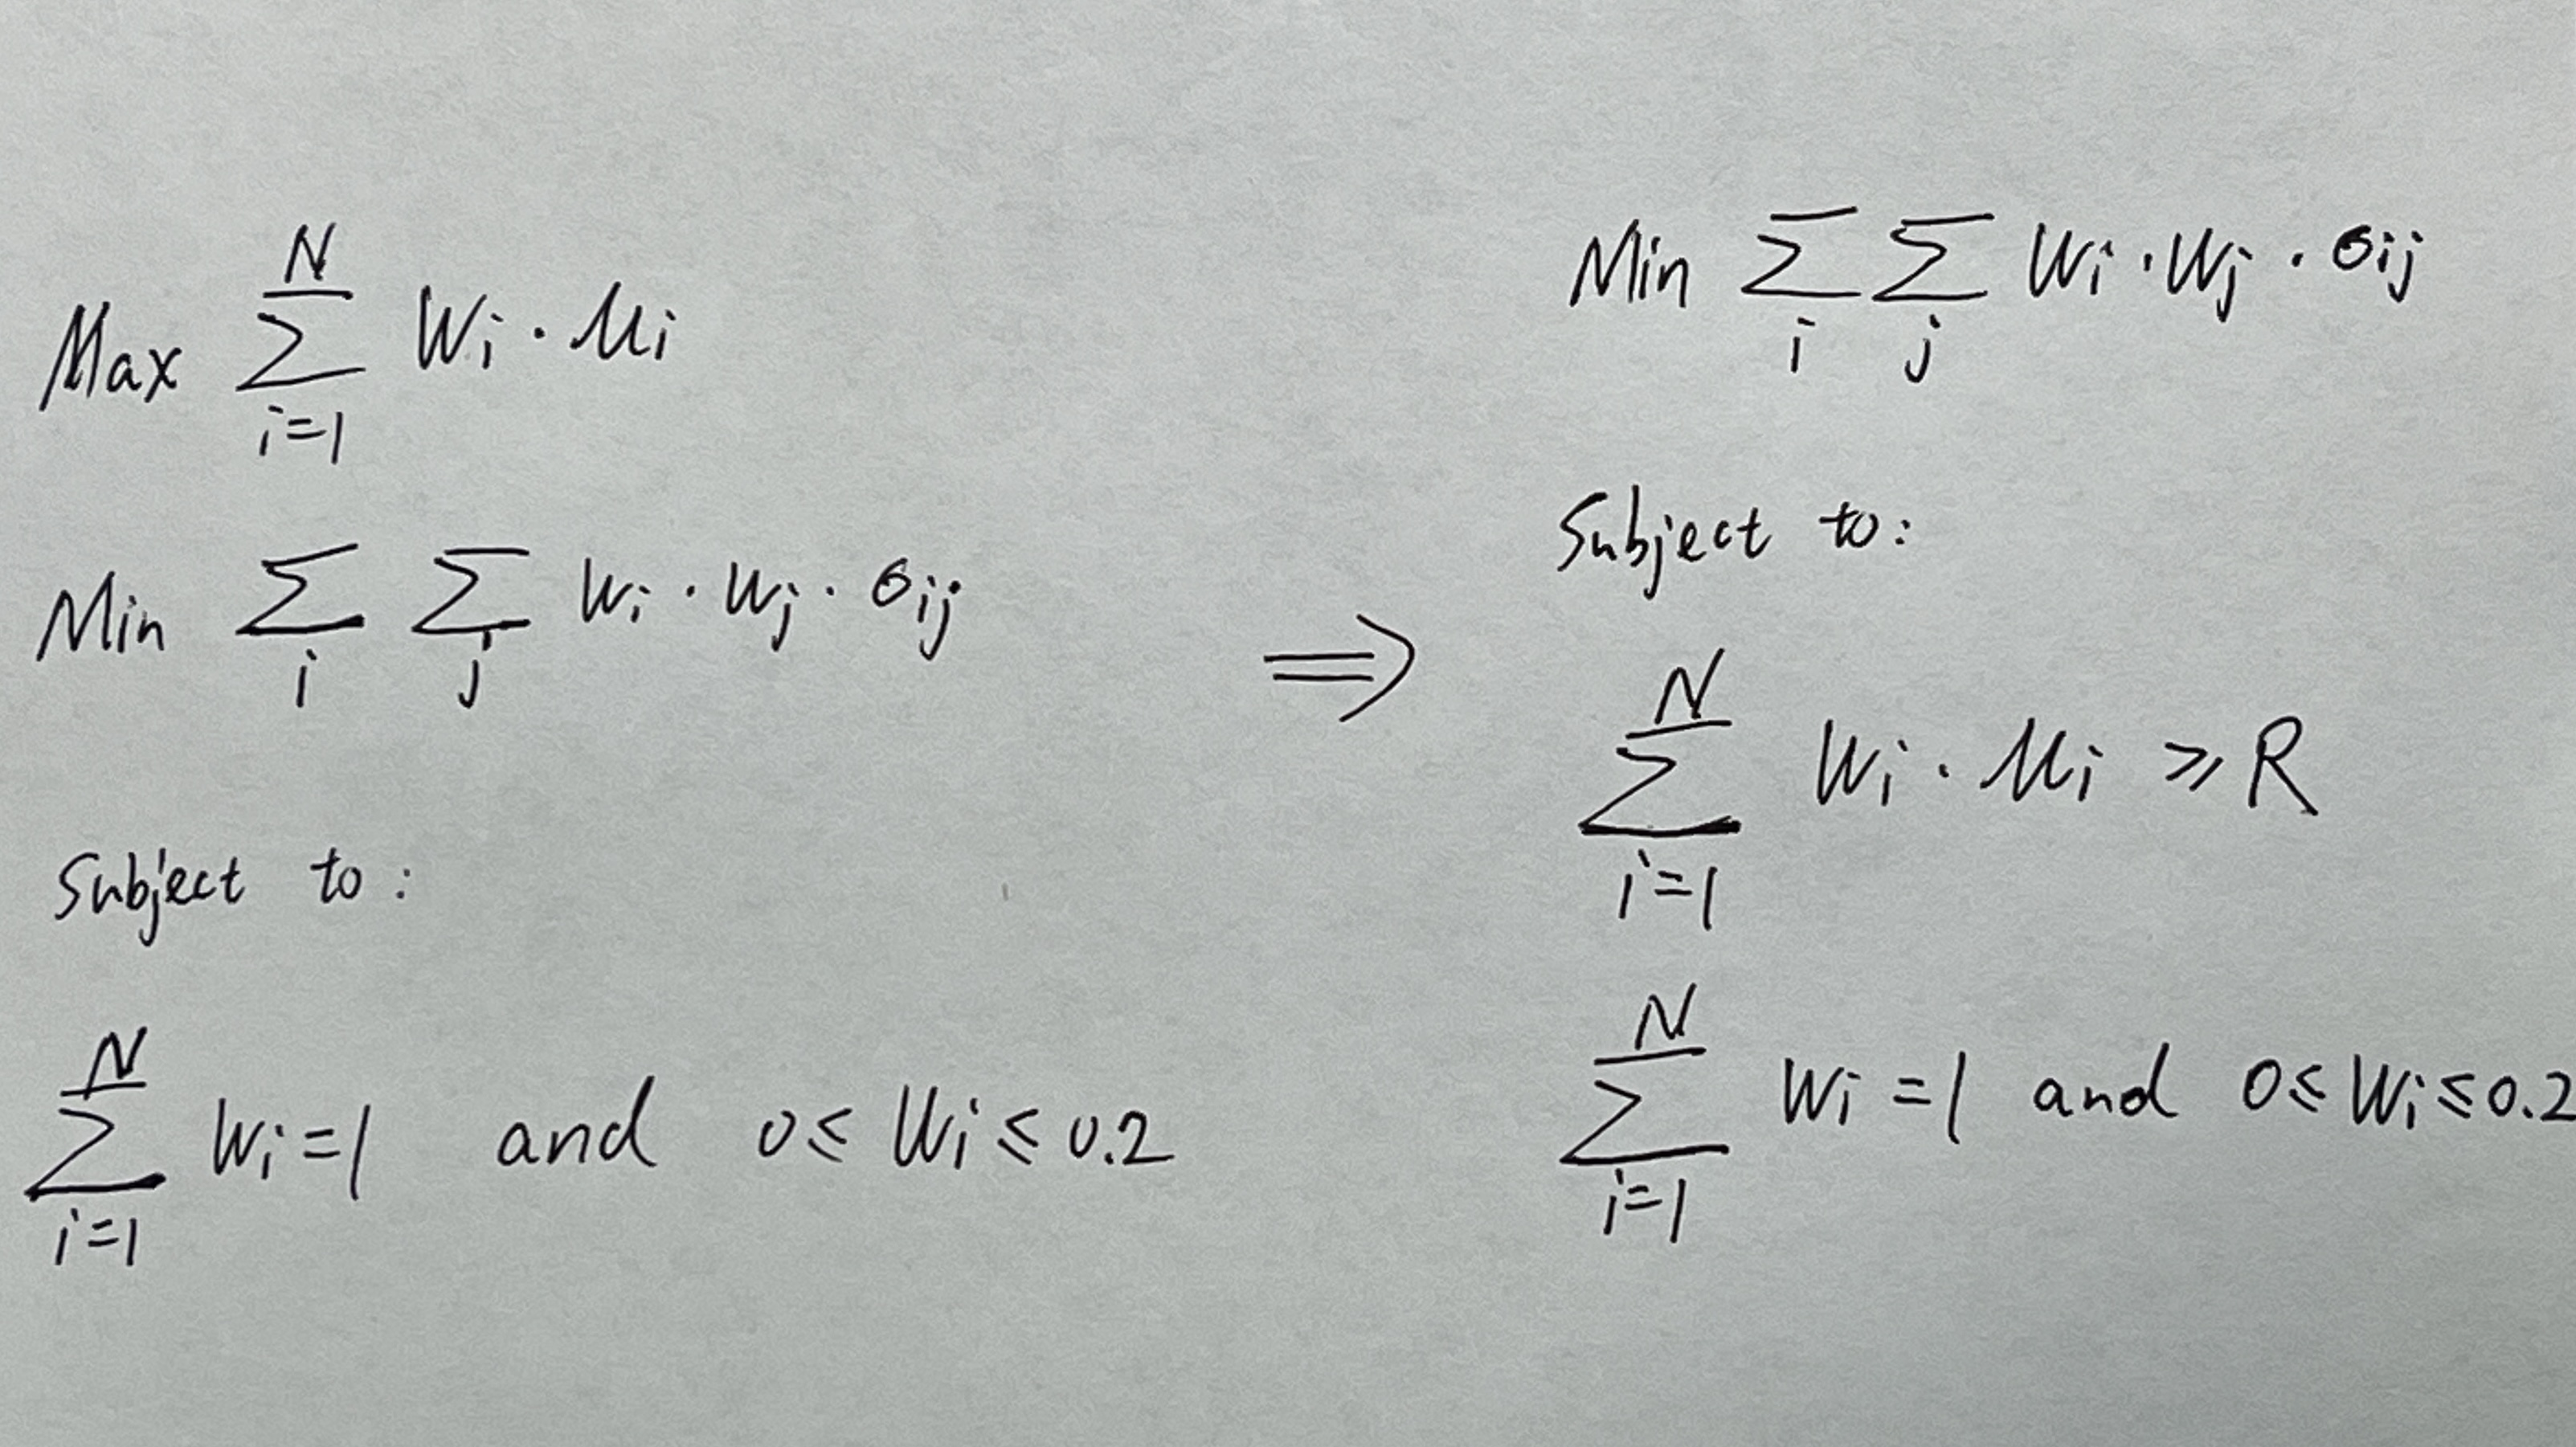

In [41]:
Image('optimization problem/IMG_1250.jpg')

In [42]:
eigvals = np.linalg.eigvalsh(portfolio_stock_cov_returns)
is_psd = np.all(eigvals >= 0)
print(is_psd)

True


This output of `True` means that our optimization problem is a convext QP, because all the eigenvalues of the matrix Q are non-negative.  
Note that we did not actually need to check the eigenvalues. This is because our Q (variance-covariance matrix) is positive semi-definite.

**Upper Bound (maximize returns subject to the constraints)**

In [43]:
# this function obtains the upper bound of portfolio returns subject to the constraints
def maximize_returns(mean_returns, portfolio_size, max_weight=0.2, investment_cap=1e6):

    # objective function
    c = -mean_returns
    
    # 1st constraint: sum of weights = 1
    A_eq = np.ones((1, portfolio_size))
    b_eq = [1]
    
    # 2nd constraint: 0 <= each weight <= 0.2
    bnds = [(0, max_weight) for _ in range(portfolio_size)]

    # invoke linear programming
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bnds, method='highs')

    allocation = investment_cap * result.x

    return result, allocation

In [44]:
result, allocation = maximize_returns(
    mean_returns=portfolio_stock_mean_returns,
    portfolio_size=len(portfolio),
    max_weight=0.2,
    investment_cap=1e6
)

if result.success:
    print('Optimization is successful!')

print('\nOptimal Weights:')
print(result.x)

max_portfolio_return = np.dot(portfolio_stock_mean_returns.T, result.x)
print('\nMaximimum Expected Portfolio Daily Return:', max_portfolio_return)
print('\nMaximimum Expected Portfolio Annualized Return:', max_portfolio_return * 252)

print('\nDollar Allocation ($):')
print(allocation)

print('\nTotal Allocation (should equal to 1M):', allocation.sum())

Optimization is successful!

Optimal Weights:
[ 0.   0.   0.   0.   0.   0.2  0.2  0.   0.   0.   0.   0.   0.   0.
  0.2  0.   0.   0.   0.2  0.2  0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0. ]

Maximimum Expected Portfolio Daily Return: 0.0035481025115523535

Maximimum Expected Portfolio Annualized Return: 0.8941218329111931

Dollar Allocation ($):
[     0.      0.      0.      0.      0. 200000. 200000.      0.      0.
      0.      0.      0.      0.      0. 200000.      0.      0.      0.
 200000. 200000.      0.     -0.      0.      0.      0.      0.      0.
      0.      0.      0.]

Total Allocation (should equal to 1M): 1000000.0


In [45]:
indices = np.argsort(portfolio_stock_mean_returns)[::-1]
print("positions (indexes) of stocks sorted from highest mean return to lowest:")
print(indices)

positions (indexes) of stocks sorted from highest mean return to lowest:
[ 5 14  6 19 18 21 26 16 10  2  3 15  0 23 11 17  7 12  4 25 27  1  9 20
 28  8 29 22 24 13]


Note that it makes sense that the optimizer picked indices `[5, 6, 14, 18, 19]` because they had the highest mean returns among the 30 stocks.

**Lower Bound (minimize risk subject to the constraints)**

In [46]:
# this function obtains the portfolio return of the minimum risk subject to the constraints
def minimize_risk(cov_returns, portfolio_size, max_weight=0.2, investment_cap=1e6):

    # objective function
    def f(x, cov_returns):
        func = np.dot(np.dot(x, cov_returns), x.T)
        return func

    # 1st constraint: sum of weights = 1
    def eq_constraint(x):
        A_eq = np.ones((1,portfolio_size))
        b_eq = 1
        eq_constraint_val = np.dot(A_eq, x.T) - b_eq
        return eq_constraint_val

    # 2nd constraint: 0 <= each weight <= 0.2
    bnds = [(0, max_weight) for _ in range(portfolio_size)]
    
    # we start with equal weights as our initial guess
    x_init = np.ones(portfolio_size) / portfolio_size
    cons = ({'type': 'eq', 'fun': eq_constraint})

    opt = optimize.minimize(
        f,
        x_init,
        args = (cov_returns,),
        bounds = bnds,
        method = 'SLSQP',
        constraints = cons,
    )

    allocation = investment_cap * opt.x

    return opt, allocation

In [47]:
opt, allocation = minimize_risk(
    cov_returns=portfolio_stock_cov_returns,
    portfolio_size=len(portfolio),
    max_weight=0.2,
    investment_cap=1e6
)

if opt.success:
    print('Optimization is successful!')

print('\nOptimal Weights:')
print(opt.x)

min_risk_portfolio_return = np.dot(portfolio_stock_mean_returns.T, opt.x)
print('\nExpected Return of Minimum Risk Portfolio:', min_risk_portfolio_return)
print('\nExpected Annualized Return of Minimum Risk Portfolio:', min_risk_portfolio_return * 252)

print('\nDollar Allocation ($):')
print(allocation)

print('\nTotal Allocation (should equal to 1M):', allocation.sum())

Optimization is successful!

Optimal Weights:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]

Expected Return of Minimum Risk Portfolio: 0.0011209054488962528

Expected Annualized Return of Minimum Risk Portfolio: 0.2824681731218557

Dollar Allocation ($):
[33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333333 33333.33333333 33333.33333333
 33333.33333333 33333.33333

Interestingly, the algorithm finds that the minimum-risk portfolio happens to be equally weighted across all 30 stocks!  
Moreover, the expected annualized return of the minimum-risk portfolio (0.2825) matches exactly with the equal-weighted portfolio’s return computed earlier.

**The next sub-optimization problem deals with the following:**  
**For each `R`, `RMinRisk <= R <= RMaxReturn`, we sweep it across this range to produce the efficient sets, which are sets of optimal portfolios offering the lowest possible risk for each required return.**

In [48]:
def max_returns_min_risk(mean_returns, cov_returns, portfolio_size, R, investment_cap=1e6, max_weight=0.2):
    
    # objective function
    def f(x, cov_returns):
        func = np.dot(np.dot(x, cov_returns), x.T)
        return func

    # 1st constraint: expected portfolio return ≥ lower bound R
    def ineq_constraint(x, mean_returns, R):
        A_ineq = np.array(mean_returns)
        b_ineq = R
        ineq_constraint_val = np.dot(A_ineq, x.T) - b_ineq
        return ineq_constraint_val
        
    # 2nd constraint: sum of weights = 1
    def eq_constraint(x):
        A_eq = np.ones((1, portfolio_size))
        b_eq = 1
        eq_constraint_val = np.dot(A_eq, x.T) - b_eq
        return eq_constraint_val

    # 3rd constraint: 0 <= each weight <= 0.2
    bnds = [(0, max_weight) for _ in range(portfolio_size)]

    # we start with equal weights as our initial guess
    x_init = np.ones(portfolio_size) / portfolio_size
    cons = (
        {'type': 'eq', 'fun': eq_constraint},
        {'type':'ineq', 'fun': ineq_constraint, 'args':(mean_returns, R)}
    )

    # uses SLSQP algorithm solve OP with both equality and inequality constraints
    opt = optimize.minimize(
        f,
        x_init,
        args = (cov_returns,),
        method ='SLSQP',
        bounds = bnds,
        constraints = cons,
        tol = 1e-9
    )

    allocation = investment_cap * opt.x

    return opt, allocation

In [49]:
INCREMENT = 1e-4
LOWER_BOUND = min_risk_portfolio_return
UPPER_BOUND = max_portfolio_return

optimal_weights = []
portfolio_return_points = []
portfolio_risk_points = []

# compute efficient frontier
while LOWER_BOUND <= UPPER_BOUND:
    R=LOWER_BOUND
    opt, allocation = max_returns_min_risk(
        mean_returns=portfolio_stock_mean_returns,
        cov_returns=portfolio_stock_cov_returns,
        portfolio_size=len(portfolio),
        R=R,
        investment_cap=1e6,
        max_weight=0.2
    )

    if opt.success:
        print('Optimization successful for daily portfolio return = {:.6f}'.format(R))
        
        w = opt.x
        portfolio_return = np.dot(portfolio_stock_mean_returns, w)
        portfolio_risk = np.sqrt(np.dot(np.dot(w, portfolio_stock_cov_returns), w.T))
        
        optimal_weights.append(w)
        portfolio_return_points.append(portfolio_return)
        portfolio_risk_points.append(portfolio_risk)
        
    LOWER_BOUND += INCREMENT

# convert lists to arrays
portfolio_return_points = np.array(portfolio_return_points)
portfolio_risk_points = np.array(portfolio_risk_points)

# annualize
portfolio_return_annualized = 252 * portfolio_return_points
portfolio_risk_annualized = np.sqrt(252) * portfolio_risk_points

print('\nNumber of Efficient Set Portfolios:', len(optimal_weights))
print('\nShape of Each Efficient Set Portfolio:', np.array(optimal_weights).shape)
print('\nOptimal Weights of the Efficient Set Portfolios:')
print(np.array(optimal_weights))
print('\nAnnualized Returns of Efficient Portfolios:')
print(portfolio_return_annualized)
print('\nAnnualized Risks of Efficient Portfolios:')
print(portfolio_risk_annualized)

Optimization successful for daily portfolio return = 0.001121
Optimization successful for daily portfolio return = 0.001221
Optimization successful for daily portfolio return = 0.001321
Optimization successful for daily portfolio return = 0.001421
Optimization successful for daily portfolio return = 0.001521
Optimization successful for daily portfolio return = 0.001621
Optimization successful for daily portfolio return = 0.001721
Optimization successful for daily portfolio return = 0.001821
Optimization successful for daily portfolio return = 0.001921
Optimization successful for daily portfolio return = 0.002021
Optimization successful for daily portfolio return = 0.002121
Optimization successful for daily portfolio return = 0.002221
Optimization successful for daily portfolio return = 0.002321
Optimization successful for daily portfolio return = 0.002421
Optimization successful for daily portfolio return = 0.002521
Optimization successful for daily portfolio return = 0.002621
Optimiza

The efficient set comprises 25 distinct optimal portfolios, each satisfying all the imposed constraints. For every portfolio on this frontier, the corresponding optimal weight vector, along with its annualized risk (%) and expected annualized return (%), is now available for us to make informed investment decisions.

**Plot the Markowitz Efficient Frontier**

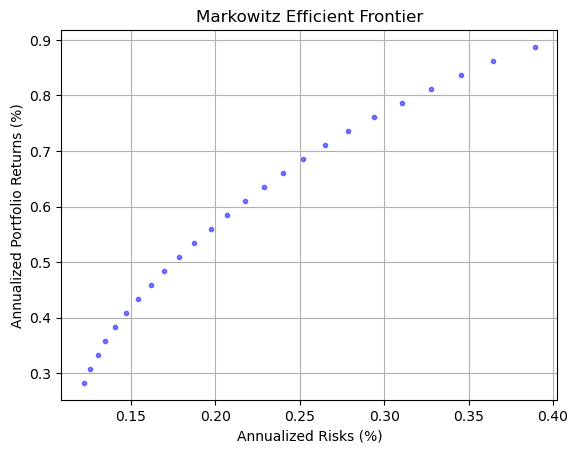

In [50]:
number_of_points = portfolio_risk_points.size

colours = 'blue'
area = np.pi * 3

plt.title('Markowitz Efficient Frontier')
plt.xlabel('Annualized Risks (%)')
plt.ylabel('Annualized Portfolio Returns (%)')
plt.scatter(portfolio_risk_annualized, portfolio_return_annualized, s=area, c=colours, alpha=0.5)
plt.grid(True)
plt.show()